In [88]:
import pandas as pd
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.forecasting.base import ForecastingHorizon

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

from sktime.forecasting.compose import ForecastingPipeline, make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.date import DateTimeFeatures

from sktime.forecasting.naive import NaiveForecaster
from sktime.datasets import load_longley

In [89]:
kwargs = {
        "lag_feature": {
            "lag": [1],
            "mean": [[1, 3], [3, 6]],
            "std": [[1, 4]],
        }
    }

y_ll, X_ll = load_longley()
y_train_ll, y_test_ll, X_train_ll, X_test_ll = temporal_train_test_split(y_ll, X_ll, test_size=0.25)
fh = ForecastingHorizon(X_test_ll.index, is_relative=False)
# Example transforming only X
pipe = ForecastingPipeline(
    steps=[
        ("a", WindowSummarizer(n_jobs=1, target_cols=["POP", "GNPDEFL"])),
        ("b", WindowSummarizer(n_jobs=1, target_cols=["GNP"], **kwargs)),
        ("forecaster", NaiveForecaster(strategy="drift")),
    ]
)
pipe_return = pipe.fit(y_train_ll, X_train_ll)
y_pred1 = pipe_return.predict(fh=fh, X=X_test_ll)
display(y_pred1)

Period
1959    67075.727273
1960    67638.454545
1961    68201.181818
1962    68763.909091
Freq: A-DEC, Name: TOTEMP, dtype: float64

In [90]:
y_ll, X_ll = load_longley()

In [91]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
import lightgbm as lgb
from sktime.forecasting.compose import RecursiveTabularRegressionForecaster
from sklearn.linear_model import Ridge

y = load_airline()

kwargs = {
    "lag_feature": {
        "lag": [1],
        "mean": [[1, 3], [3, 3]],
        "std": [[1, 5]],
    }
}
y_transformed = WindowSummarizer(**kwargs).fit_transform(y)
y_hat = DateTimeFeatures(ts_freq="M", feature_scope="minimal").fit_transform(y)

df = y_transformed.merge(y_hat, how='inner',right_index=True,left_index=True)
df = df.dropna()

y_train, y_test = temporal_train_test_split(y[df.index])
X_train, X_test  = temporal_train_test_split(df)

In [100]:
estimator = Ridge()
forecaster = RecursiveTabularRegressionForecaster(estimator=estimator,window_length=12) #transformers=[WindowSummarizer(**kwargs)]
forecaster.fit(y_train)

forecasterX = RecursiveTabularRegressionForecaster(estimator=estimator,window_length=12)
forecasterX.fit(y_train, X=X_train)

RecursiveTabularRegressionForecaster(estimator=Ridge(), window_length=12)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

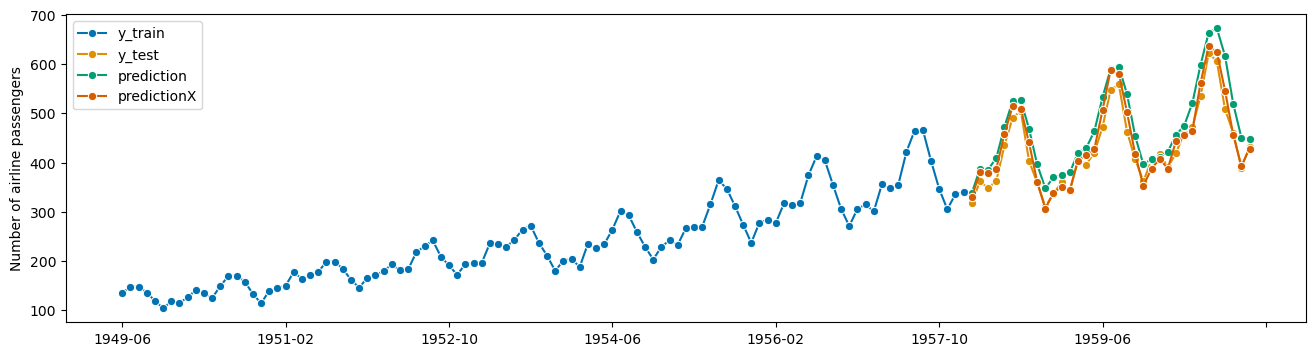

In [101]:
import warnings
warnings.filterwarnings("ignore")

fh = ForecastingHorizon(y_test.index, is_relative=False)
prediction = forecaster.predict(fh=fh)
predictionX = forecasterX.predict(fh=fh,X=X_test)

plot_series(y_train, y_test, prediction,predictionX, labels=["y_train", "y_test","prediction","predictionX"])

In [116]:
#compute mape
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test, prediction)
mapeX = mean_absolute_percentage_error(y_test, predictionX)

print(f"MAPE:{round(mape*100, 1)} %")
print(f"MAPEX:{round(mapeX*100,1)} %")

MAPE:9.2 %
MAPEX:3.6 %


In [97]:
#forecaster.get_fitted_params()

{'estimator': Ridge(),
 'transformers': None,
 'window_length': 12,
 'estimator__coef': array([ 0.63114133,  0.33377481, -0.24243688,  0.23929597, -0.22497696,
         0.14631163, -0.18700485,  0.22709426, -0.23343335,  0.19466075,
        -0.24148998,  0.43109512]),
 'estimator__intercept': 7.160649458709429,
 'estimator__n_features_in': 12,
 'estimator__n_iter': None}